# Sentiment classifier with LSTM

In this notebook, we will implement a simple sentiment classifier using an LSTM. Follow the notebook, complete the missing part, answer the questions and apply the asked modifications.



In [1]:
!pip install datasets

In [2]:
from collections import defaultdict
from copy import deepcopy
import re
from typing import Callable, List, Tuple

from datasets import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from tqdm.auto import tqdm
from datetime import datetime
from sklearn.utils import shuffle

## Downloading the dataset

Using the datasets library, we load the imdb dataset.

In [3]:
dataset = load_dataset("imdb")

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb downloaded and prepared to /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [5]:
# We do not need the "unsupervised" split.
dataset.pop("unsupervised")

Dataset({
    features: ['text', 'label'],
    num_rows: 50000
})

In [6]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [7]:
dataset["train"][:2]

{'text': ['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far b

## Pretreatment **(1 point)**

Code the `pretreatment` function which clean the input text. Look at the dataset and deduce which treatment is needed.

In [8]:
!pip install nltk

In [9]:
#library needed for pretreatment
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation

In [10]:
#get stopwords
nltk.download('stopwords')
stops = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def remove_stop_words(text: str) -> str:
    """Remove stopwrods from the string.
    Args: 
        text: an input string.
    Returns:
        The text without stopword.
    """
    text_words = text.split()
    text_no_stop = [word for word in text_words if word not in stops]
    res = ' '.join(text_no_stop)
    return res


In [12]:
def pretreatment(text: str) -> str:
    """Clean IMDB text entries.
    Args:
        text: an input string.
    Returns:
        The cleaned text.
    """
    text = text.lower()
    for e in '[{}]'.format(punctuation):
        text = text.replace(e,'')
    text = remove_stop_words(text)
    return text


In [13]:
# This applies the pretreatment function to all
clean_dataset = dataset.map(lambda x: {"text": pretreatment(x["text"]), "label": x["label"]})

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

In [14]:
clean_dataset["train"]["text"][:3]

['rented curiousyellow video store controversy surrounded first released 1967 also heard first seized us customs ever tried enter country therefore fan films considered controversial really see myselfbr br plot centered around young swedish drama student named lena wants learn everything life particular wants focus attentions making sort documentary average swede thought certain political issues vietnam war race issues united states asking politicians ordinary denizens stockholm opinions politics sex drama teacher classmates married menbr br kills curiousyellow 40 years ago considered pornographic really sex nudity scenes far even shot like cheaply made porno countrymen mind find shocking reality sex nudity major staple swedish cinema even ingmar bergman arguably answer good old boy john ford sex scenes filmsbr br commend filmmakers fact sex shown film shown artistic purposes rather shock people make money shown pornographic theaters america curiousyellow good film anyone wanting study

Let's take a quick look at the labels. Notice that the labels are ordered in the training set starting by the negative reviews (0), followed by the positive ones (1). Training neural networks on this kind of configuration tends to considerably affect their performances. So the dataset will have to be shuffled.

In [15]:
clean_dataset["train"]["label"][12490:12510]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

## Train/validation split **(1 point)**

In our example, we consider the test split as production data. Which means, we need to treat it as if we never see it during the training process. To experiment on the model, we need to split the training set into a training and validation set. See [here](https://huggingface.co/course/chapter5/3?fw=pt#creating-a-validation-set) on how to do so with the `Datasets` library.

Don't forget to **stratify** your split (we need to have the same proportion of class in both training and validation set).

In [16]:
from sklearn.model_selection import train_test_split
training_set, validation_set = train_test_split(clean_dataset["train"], test_size = 0.2)

In [17]:
#Creation of the DatasetDict general
import datasets
dataset_dict = datasets.DatasetDict({
   "train": Dataset.from_dict(training_set),
   "test": clean_dataset["test"],
    "validation": Dataset.from_dict(validation_set)
})

In [18]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

In [19]:
# Check here that the dataset is stratified.

In [20]:
label_zero = 0
label_one = 0
for e in (dataset_dict["train"]["label"]):
    if (e == 1):
        label_zero +=1
    else:
        label_one +=1 
label_zero, label_one

(10003, 9997)

In [21]:
label_zero = 0
label_one = 0
for e in (dataset_dict["validation"]["label"]):
    if (e == 1):
        label_zero +=1
    else:
        label_one +=1 
label_zero, label_one

(2497, 2503)

The dataset are considered well startified here

## Categorical encoding of the vocabulary **(2 points)**

We can't feed word to a neural network. A usual solution is to turn words into categorical data by using one-hot encoding. To avoid an explosion in vocabulary size, we will only keep words which appear more than a certain amount of time.

The `Vocabulary` class below will do that for us.

In [22]:
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"


class Vocabulary:
    """Vocabulary manager on a collection.
    """
    def __init__(self) -> None:
        """No parameters to provide.
        """
        # Index to word mapping.
        self.index2word = [PAD_TOKEN, UNK_TOKEN]
        # Word to index mapping.
        self.word2index = {value: key for key, value in enumerate(self.index2word)}
        # Word counter.
        self.word2count = defaultdict(int)

    def adataset_dict_word(self, word: str) -> None:
        """Increments the count of a word to the vocabulary.
        Args:
            word: the word.
        """
        self.word2count[word] += 1
        if not word in self.word2index:
            self.word2index[word] = len(self.index2word)
            self.index2word.append(word)

    def adataset_dict_text(self, text: str, separator: str =" ") -> None:
        """Adataset_dict the words given in a text to our vocabulary.
        Args:
            text: a sequence of words separated by a given separator.
            separator: the separator used to split our text (default is " ").
        """
        for word in text.split(separator):
            self.adataset_dict_word(word)

    def get_index(self, word: str) -> int:
        """Returns the index of a given word in our vocabulary.
        If the word is not in the vocabulary, returns the index for UNK_TOKEN.
        Args:
            word: a string.
        Returns:
            The corresponding index or the index for UNK_TOKEN.
        """
        return (
            self.word2index[word]
            if word in self.word2index
            else self.word2index[UNK_TOKEN]
        )

    def get_word(self, index: int) -> str:
        """Returns the word at a given index in our vocabulary.
        Args:
            index: the word position in our vocabulary.
        Returns:
            The word corresponding to the given index.
        """
        return self.index2word[index]

    def get_word_count(self, word: str) -> int:
        """Returns the number of occurences for a given word.
        Raise a 
        Args:
            The word.
        Returns:
            Its number of measured occurences.
        """
        return self.word2count[word]

    def get_vocabulary(self) -> List[str]:
        """Returns a copy of the whole vocabulary list.
        Returns:
            A list of words.
        """
        return deepcopy(self.index2word)

    def __len__(self) -> int:
        """len() function.
        Returns:
            The number of words in the vocabulary.
        """
        return len(self.index2word)

    def trim_vocabulary(self, min_occurences: int = 5) -> None:
        """Trim the vocabulary based on the number of occurrences of each words.
        Note that whole counts of deleted words are adataset_dicted to the UNK_TOKEN counts.
        Args:
            min_occurences: the minimum number of occurences for a word to be kept.
        """
        to_delete = {
            word for word, count in self.word2count.items() if count < min_occurences
        }
        new_word2count = defaultdict(int)
        for word, count in self.word2count.items():
            if word not in to_delete:
                new_word2count[word] = count
            else:
                new_word2count[UNK_TOKEN] += count
        new_index2word = [word for word in self.index2word if word not in to_delete]
        new_word2index = {word: index for index, word in enumerate(new_index2word)}

        self.word2count = new_word2count
        self.index2word = new_index2word
        self.word2index = new_word2index

**(1 point)** Get the vocabulary on both the training and validation set using the `Vocabulary` class. Remember, we don't use the test set here as we consider it as proxy production data. The trim it down as you see fit (around 20K words in the vocabulary is a good value).

In [23]:
def get_vocabulary_dataset(dataset: dict, size_max: int):
    """Get the vocabulary of the dataset and trim it until the lenght of it is under the size maximum.
    Args: 
        dataset: the dataset to get the vocabulary from.
        size_max: the size max of the vocabulary.
    Returns:
        The list of words of the vocabulary."""
    vocabulary = Vocabulary()
    for text in dataset["text"]:
        vocabulary.adataset_dict_text(text)

    i = 1
    while (len(vocabulary) > size_max):
        vocabulary.trim_vocabulary(i)
        i += 1
    
    return vocabulary

In [24]:
training_vocab = Vocabulary()
training_vocab = get_vocabulary_dataset(dataset_dict["train"],20000)
len(training_vocab.get_vocabulary())

19919

In [25]:
validation_vocab = Vocabulary()
validation_vocab = get_vocabulary_dataset(dataset_dict["validation"],20000)
len(validation_vocab.get_vocabulary())

18507

**(1 point)** Fill the encoding and decoding functions. The encoding function takes a text as input and returns a list IDs corresponding to the index of each word in the vocabulary. The decoding function reverse the process, turning a list of IDs into a text. Make sure the encoding function returns a numpy array.

In [26]:
# Encoding and decoding function
from base64 import encode


vocab = training_vocab
def encode_text(text: str) -> np.ndarray:
    encoded_text = []
    for word in text.split():
        encoded_text.append(vocab.get_index(word))
    return encoded_text

def decode_text(encoded_text: np.ndarray) -> str:
    decoded_text = []
    for index in encoded_text :
        decoded_text.append(vocab.get_word(index))
    return decoded_text

In [27]:
# Apply the encoding function to the entire dataset.
encoded_dataset = dataset_dict.map(lambda x: {"text": encode_text(x["text"]), "label": x["label"]})

  0%|          | 0/20000 [00:00<?, ?ex/s]

  0%|          | 0/25000 [00:00<?, ?ex/s]

  0%|          | 0/5000 [00:00<?, ?ex/s]

To make sure everything went well, we compare a text before and after encoding and then decoding it. You should see rare words / typos replaced by the `<UNK>` token.

In [28]:
dataset_dict["train"]["text"][0], decode_text(encoded_dataset["train"]["text"][0])

('flock really movie wannabe movie wannabe actors including richard gere gave excellent performance one actors truly gives character rest cast acting result pathetic like movie see idea acting hide fact youre acting hell claire dains one shes inappropriate actress character 999 movie looked extremely place everything thing asking stupid questions like really think making silly faces embarrassed acting seriously used like shes romantic movie type dont know picked among actresses lol seeing avril lavigne really made laugh anyway want get feeling throwing movie job wish could vote 5',
 ['flock',
  'really',
  'movie',
  'wannabe',
  'movie',
  'wannabe',
  'actors',
  'including',
  'richard',
  'gere',
  'gave',
  'excellent',
  'performance',
  'one',
  'actors',
  'truly',
  'gives',
  'character',
  'rest',
  'cast',
  'acting',
  'result',
  'pathetic',
  'like',
  'movie',
  'see',
  'idea',
  'acting',
  'hide',
  'fact',
  'youre',
  'acting',
  'hell',
  'claire',
  '<UNK>',
  'o

## Batch preparation **(1 point)**

To speed up learning, and take advantage of the GPU architecture, we provide data to the model by batches. Since all line in the same batch need to have the same length, we pad lines to the maximum length of each batch.

In [29]:
def data_generator(X: np.ndarray, y: np.ndarray, batch_size: int = 32, pad_right: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    """Generate randomly ordered batches of data+labels.
    Args:
        X: the input data.
        y: the corresponding labels.
        batch_size: the size of each batch [32].
        pad_right: if true, the padataset_dicting is done on the right [False].
    """
    
    X, y = shuffle(X, y)
    n_batches = int(np.ceil(len(y) / batch_size))
    
    for i in range(n_batches):
        
        end = min((i+1)*batch_size, len(y))
        
        X_batch = X[i*batch_size:end]
        y_batch = y[i*batch_size:end]

        # Padataset_dicting to max ength size within the batch
        max_len = np.max([len(x) for x in X_batch])
        for j in range(len(X_batch)):
            x = X_batch[j]
            pad = [training_vocab.get_index(PAD_TOKEN)] * (max_len - len(x))
            X_batch[j] = x+pad if pad_right else pad+x

        X_batch = torch.from_numpy(np.array(X_batch)).long()
        y_batch = torch.from_numpy(np.array(y_batch)).long()

        # Yielding results, so every time the function is called, it starts again from here.
        yield X_batch, y_batch

Let's see what the batches look like.

In [30]:
for inputs, labels in data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"], pad_right=True):
    print("inputs:\n", inputs, "\nshape:\n", inputs.shape)
    print("labels:\n", labels, "\nshape:\n", labels.shape)
    break

inputs:
 tensor([[  269,    76,     4,  ...,     0,     0,     0],
        [  757,     1,  3778,  ...,     0,     0,     0],
        [ 9963,  8735,   418,  ...,     0,     0,     0],
        ...,
        [    1, 10838,   544,  ...,     0,     0,     0],
        [ 6297,  6615,   352,  ...,     0,     0,     0],
        [10837, 11004,  9783,  ...,     0,     0,     0]]) 
shape:
 torch.Size([32, 271])
labels:
 tensor([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
        1, 1, 1, 1, 1, 0, 0, 0]) 
shape:
 torch.Size([32])


**(1 point)** Question: On which side should we pad the data for our use case and why?

We should pad the data to the right. Indeed with this padataset_dicting, the model will see in a first time the indexes of the text which conveys the important information and not the succsession of 0 that represents empty slots to fill the sentence to the max lenght.

## The model **(13 points)**

We use a simple RNN with a configurable number of layers.

In [31]:
# Before starting, let's set up the device. A GPU if available, else the CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [32]:
class RNN(nn.Module):
    """A simple RNN module with word embeddings..
    """
    def __init__(self, vocab_size: int, embed_size: int, hidden_size: int, n_layers: int, n_outputs: int) -> None:
        """
        Args:
            vocab_size: vocabulary size.
            embed_size: embedataset_dicting dimensions.
            hidataset_dicten_size: hidataset_dicten layer size.
            n_layers: the number of layers.
            n_outputs: the number of output classes.
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.n_outputs = n_outputs


        # The word embedataset_dicting layer.
        self.embed = nn.Embedding(self.vocab_size, self.embed_size)
        # The RNN
        self.rnn = nn.RNN(
            input_size = self.embed_size,
            hidden_size = self.hidden_size,
            num_layers = self.n_layers,
            batch_first = True, # Changes the order of dimension to put the batches first.
        )
        # A fully connected layer to project the RNN's output to only one output used for classification.
        self.fc = nn.Linear(self.hidden_size, self.n_outputs)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """Function called when the model is called with data as input.
        Args:
            X: the input tensor of dimensions batch_size, sequence length, vocab size (actually just an int).
        Returns:
            The resulting tensor of dimension batch_size, sequence length, output dimensions.
        """
        h0 = torch.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)

        out = self.embed(X)
        # out contains the output layer of all words in the sequence.
        # First dim is batch, second the word in the sequence, third is the vector itself.
        # The second output value is the last vector of all intermediate layer.
        # Only use it if you want to access the intermediate layer values of a
        # multilayer model.
        out, _ = self.rnn(out, h0)
        # Getting the last value only.
        out = out[:, -1, :]
    
        # Linear projection.
        out = self.fc(out)

        return out

Note that we do not pass the output through a sigmoid function. This is because pyTorch implements some code optimization within the `BCEWithLogitsLoss` we'll see later.

In [33]:
import copy
from copy import deepcopy

def train(
    model: nn.Module,
    criterion: Callable,
    optimizier: torch.optim.Optimizer,
    n_epochs: int,
    train_gen: Callable,
    valid_gen: Callable,
) -> Tuple[List[float], List[float]]:
    """Train a model using a batch gradient descent.
    Args:
        model: a class inheriting from nn.Module.
        criterion: a loss criterion.
        optimizer: an optimizer (e.g. Adam, RMSprop, ...).
        n_epochs: the number of training epochs.
        train_gen: a callable function returing a batch (data, labels).
        valid_gen: a callable function returing a batch (data, labels).
    """
    train_losses = np.zeros(n_epochs)
    valid_losses = np.zeros(n_epochs)
    model_to_save = None
    lowest_loss = 0

    for epoch in range(n_epochs):

        t0 = datetime.now()
        model.train()
        train_loss = []

        # Training loop.
        for inputs, labels in train_gen():
            # labels are of dimension (N,) we turn them into (N, 1).
            labels = labels.view(-1, 1).float()
            # Put them on the GPU.
            inputs, labels = inputs.to(device), labels.to(device)

            # Reset the gradient.
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizier.step()

            train_loss.append(loss.item())  # .item() detach the value from GPU.

        train_losses[epoch] = np.mean(train_loss)

        model.eval()
        valid_loss = []
        # Evaluation loop.
        for inputs, labels in valid_gen():
            labels = labels.view(-1, 1).float()
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            valid_loss.append(loss.item())

        valid_losses[epoch] = np.mean(valid_loss)
        
        ### CODE MODIFIED TO STOP THE TRAINING IF OVERFITTING
        
        if (valid_losses[epoch] < lowest_loss) or (lowest_loss == 0):
            lowest_loss = valid_losses[epoch]
            model_to_save = copy.deepcopy(model)

        print(f"Epoch: {epoch}, training loss: {train_losses[epoch]}, validation loss: {valid_losses[epoch]}, in {datetime.now() - t0}")

    return train_losses, valid_losses, model_to_save

We setup the model, criterion (a binary cross entropy), and the optimizer (Adam).

Note that `BCEWithLogitsLoss` use a mathematical trick to incorporate the sigmoid function in its computation. This trick makes the learning process go slightly faster and is the reason why we didn't put a sigmoid in the forward function of the model.

In [34]:
model = RNN(len(training_vocab), 32, 64, 1, 1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

We get the 3 generators.

In [35]:
train_gen = lambda: data_generator(encoded_dataset["train"]["text"], encoded_dataset["train"]["label"])
valid_gen = lambda: data_generator(encoded_dataset["validation"]["text"], encoded_dataset["validation"]["label"])
test_gen = lambda: data_generator(encoded_dataset["test"]["text"], encoded_dataset["test"]["label"])

In [36]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

And train the model.

In [37]:
train_losses, valid_losses, model = train(model, criterion, optimizer, 10, train_gen, valid_gen)

Epoch: 0, training loss: 0.6762918057441711, validation loss: 0.6617666809422196, in 0:00:12.283113
Epoch: 1, training loss: 0.5956799233913421, validation loss: 0.6511348091113339, in 0:00:10.971826
Epoch: 2, training loss: 0.5417112821102142, validation loss: 0.5155054465600639, in 0:00:10.785705
Epoch: 3, training loss: 0.4259020669221878, validation loss: 0.45566746554556925, in 0:00:10.790416
Epoch: 4, training loss: 0.3701060254335403, validation loss: 0.45481234390264863, in 0:00:11.129887
Epoch: 5, training loss: 0.46372013520002364, validation loss: 0.566658128598693, in 0:00:10.840268
Epoch: 6, training loss: 0.3855380420923233, validation loss: 0.44963209122229536, in 0:00:10.876470
Epoch: 7, training loss: 0.34598712483644484, validation loss: 0.6380320616588471, in 0:00:11.173702
Epoch: 8, training loss: 0.3862461616277695, validation loss: 0.4658047909949236, in 0:00:10.786664
Epoch: 9, training loss: 0.2616734348356724, validation loss: 0.4787764188590323, in 0:00:11.009

We can look at the training and validation loss.

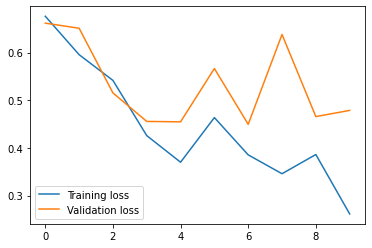

In [38]:
plt.plot(train_losses, label="Training loss")
plt.plot(valid_losses, label="Validation loss")
plt.legend()

For the assignment, code the following.
* **(2 points)** The model validation loss should go down and then up. It means the model starts overfitting after a certain number of iterations. Modify the `train` function so it returns the model found with the best validation loss.
* **(2 points)** Adataset_dict an accuracy function and report the accuracy of the training and test set.
* **(3 points)** Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.
* **(2 point)** Implement a function which takes any text and return the model's prediction.
    * The function should have a string as input and return a class (0 or 1) and its probability (score out of a [sigmoid](https://pytorch.org/docs/stable/generated/torch.sigmoid.html)).
    * Don't forget to make the text go through the same pretreatment and encoding you used to train your model.
* **(3 points)** Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.
    * To combine the last output of both direction, you can concatenate, adataset_dict, or max-pool them. Please document your choice.
* **(1 point)** With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.
* **(Bonus)** Try finding better hyperparameters (dimensions, number of layers, ...). Document your experiments and results.

(2 points) The model validation loss should go down and then up. It means the model starts overfitting after a certain number of iterations. Modify the train function so it returns the model found with the best validation loss.

See the code above.

(2 points) Adataset_dict an accuracy function and report the accuracy of the training and test set.

In [39]:
def get_accuracy(model, data_gen):
    """Returns the accuracy value of the model
    Args:
    model: the model.
    data_gen: the dataset on which we calculate the accuracy.
    
    Returns: The accuracy score.
    """
    for inputs, labels in data_gen():
        labels = labels.view(-1,1).float()
        inputs = inputs.to(device)
        lables = labels.to(device)
        
        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        outputs = outputs.to(device)
        
        tmp = []
        for e in outputs:
            if (e.item() >= 0.5):
                tmp.append(1)
            else :
                tmp.append(0)
        
        correct_prediction = 0
        number_of_prediction = 0
        
        for i in range(len(inputs)):
            if (labels[i].to(device) == tmp[i]):
                correct_prediction += 1
            number_of_prediction += 1
    accuracy = correct_prediction / number_of_prediction
    print(f"The accuracy of the model is {accuracy} \n")
    return 

In [40]:
get_accuracy(model,test_gen)
get_accuracy(model,train_gen)

/opt/conda/lib/python3.7/site-packages/torch/nn/modules/rnn.py:473: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /usr/local/src/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  self.batch_first)


The accuracy of the model is 0.875 

The accuracy of the model is 0.875 



(3 points) Create an LSTM class which uses an LSTM instead of an RNN. Compare its results with the RNN.

In [41]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(output[:,-1,:])

In [42]:
model_LSTM = LSTM(len(training_vocab), 100, 128, 1, 2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_LSTM.parameters())

In [43]:
get_accuracy(model_LSTM,test_gen)
get_accuracy(model_LSTM,train_gen)

The accuracy of the model is 0.5 

The accuracy of the model is 0.40625 



(2 point) Implement a function which takes any text and return the model's prediction.

    -The function should have a string as input and return a class (0 or 1) and its probability (score out of a sigmoid).
    -Don't forget to make the text go through the same pretreatment and encoding you used to train your model.

In [44]:
def predict(text, model):
    """Predict the result of the sentence, 1 if positive 0 if negative.
    Args:
    text : the sentence to predict.
    model: the model.
    
    Returns: 1 or 0
    """
    #To fix the parameters
    model.eval()
    text = pretreatment(text)
    # The text is encoded to
    text = torch.tensor(encode_text(text)).view(1, -1).to(device)
    output = model(text)
    output = torch.sigmoid(output)
    output = (output > 0.5).float()
    return output.item()

In [45]:
#test de la prediction

predict("I liked this movie, the soundtrack is impressive, the actors play very well!",model)

1.0

In [46]:
#test de la prediction
predict("Film to flee, waste of time and money, the actors are not at all credible in their roles",model)

0.0

(3 points) Create a bidirectional LSTM (BiLSTM) class to classify your sentences. Report the accuracy on the training and test data.

In [71]:
class BiLSTM(nn.Module):
    def init(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers):
        super().init()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=True ,batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedataset_dicted = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        return self.fc(output[:,-1,:])

(1 point) With your best classifier, look at two wrongly classified examples on the test set. Try explaining why the model was wrong.

In [61]:
def get_index(prediction):
    """Description
    Args:
        prediction: Series containing a binary prediction
    Return:
        res: List of elements that were not guessed correctly
    """
    columns = ['pred','label']
    df = pd.DataFrame(list(zip(prediction,dataset_dict["test"]["label"])),columns=columns)
    res = []
    for index,row in df.iterrows():
        if row["pred"] != row["label"]:
            res.append(index)
    return res

In [56]:
dataset_dict["test"] = dataset_dict["test"].add_column("prediction", [predict(i,model) for i in dataset_dict["test"]["text"]])

In [57]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    test: Dataset({
        features: ['text', 'label', 'prediction'],
        num_rows: 25000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
})

In [63]:
incorrect = get_index(dataset_dict["test"]["prediction"])
for i in range(5):
    if i<len(incorrect):
        print(dataset_dict["test"]["text"][incorrect[i]])
        print("\n ------------------------------\n")

star rating saturday night friday night friday morning sunday night monday morning br br former new orleans homicide cop jack robideaux jean claude van damme reassigned columbus small violent town mexico help police efforts stop major heroin smuggling operation town culprits turn exmilitary lead former commander benjamin meyers stephen lord otherwise known jase east enders using special method learned afghanistan fight opponents jack personal reason taking draws two men explosive final showdown one walk away alivebr br death van damme appeared high showing could make best straight video films action market far drama oriented film shepherd returned highkicking brainer action first made famous sadly produced worst film since derailed nowhere near bad film said still standsbr br dull predictable film little way exciting action little mainly consists limp fight scenes trying look cool trendy cheap slomosped effects added sadly instead make look desperate mexican set film director isaac flo

The reason why the model did not classify well these examples is because the autors are using negative words in their sentences but to give a good opinion of the movie. Then it become harder for the model to classify them into the goood label.